In [33]:
# --- 1. Data Cleaning ---
# We previously identified that 'resting bp s' and 'cholesterol' have
# physiologically impossible zero values. We'll replace them with the median.
for col in ['resting bp s', 'cholesterol']:
    median_val = df[col].median()
    df[col] = df[col].replace(0, median_val)
print("Data cleaning complete: '0' values in 'resting bp s' and 'cholesterol' handled.")

# --- 2. Define Features (X) and Target (y) ---
X = df.drop('target', axis=1)
y = df['target']
print("Features and target variable have been separated.")

# --- 3. Split Data into Training and Testing Sets ---
# We'll use 80% of the data for training and 20% for testing.
# 'stratify=y' ensures the proportion of heart disease vs. no heart disease
# is the same in both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")

# --- 4. Scale Features ---
# Scaling is crucial for models like SVM and Logistic Regression.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features have been scaled using StandardScaler.")

# For convenience, let's convert the scaled arrays back to DataFrames
# to keep the column names, which is useful for the next steps.
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

Data cleaning complete: '0' values in 'resting bp s' and 'cholesterol' handled.
Features and target variable have been separated.
Data split into training (952 rows) and testing (238 rows) sets.
Features have been scaled using StandardScaler.


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


file_path = '/Users/chandu/MachineLearning_Project/Unified_mentor(Internship)/Projects/My_List/Heart Disease/HD.csv'
df = pd.read_csv(file_path)
print(f"Dataset '{file_path}' loaded successfully.")

Dataset '/Users/chandu/MachineLearning_Project/Unified_mentor(Internship)/Projects/My_List/Heart Disease/HD.csv' loaded successfully.


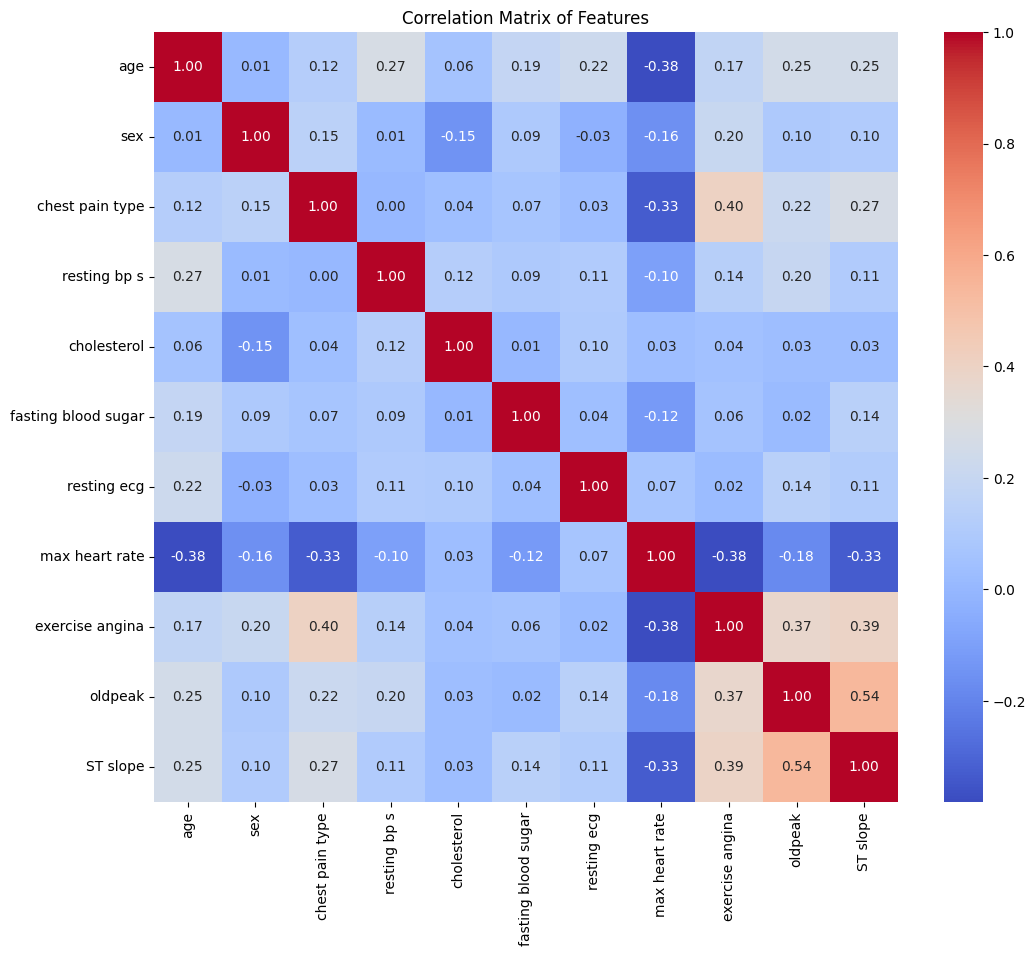

In [35]:
#2. EDA
# --- 2.1 Correlation Heatmap ---
# We'll use the scaled training data to generate the heatmap.
plt.figure(figsize=(12, 10))
correlation_matrix = X_train_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

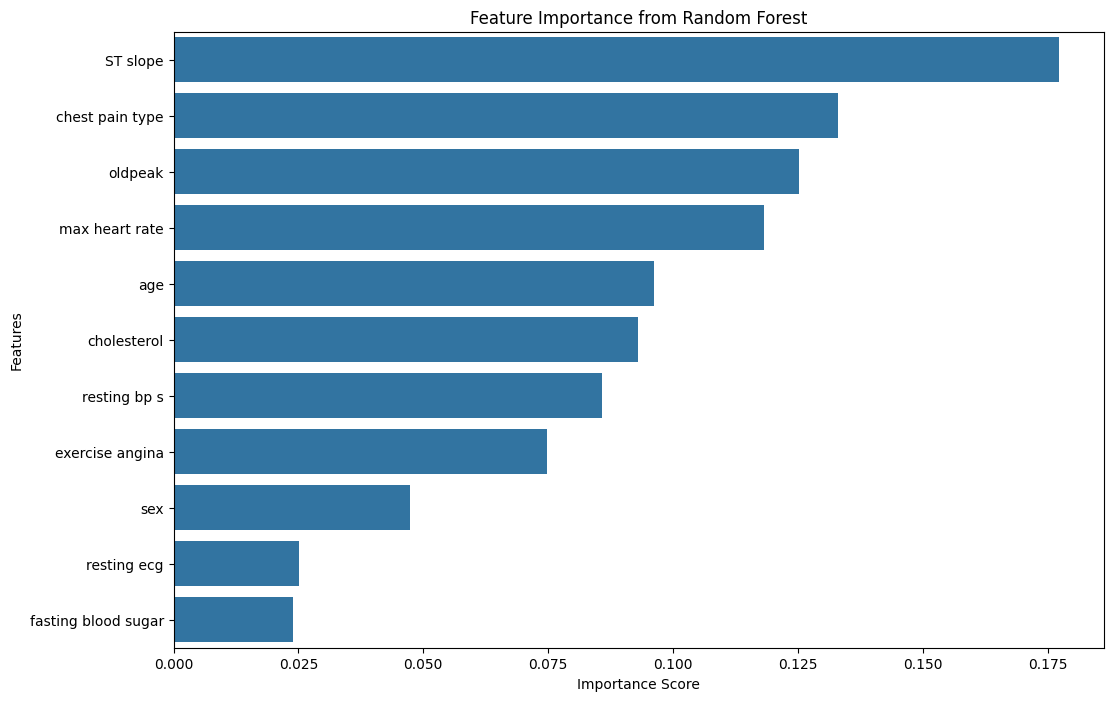

--- Feature Importances ---
                Feature  Importance
10             ST slope    0.177306
2       chest pain type    0.132943
9               oldpeak    0.125160
7        max heart rate    0.118179
0                   age    0.096100
4           cholesterol    0.093052
3          resting bp s    0.085814
8       exercise angina    0.074854
1                   sex    0.047434
6           resting ecg    0.025195
5   fasting blood sugar    0.023961


In [36]:
#--3. Feature Selection--

# --- 3.1 Get Feature Importances from Random Forest ---
# We fit a Random Forest Classifier on the training data.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# We extract the importance scores.
importances = rf_classifier.feature_importances_

# Let's create a DataFrame to visualize the scores.
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# And now, we plot the results.
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print("--- Feature Importances ---")
print(feature_importance_df)

In [37]:
# --- Complete, Self-Contained Feature Selection Step ---

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd

# We assume 'X_train_scaled' and 'X_test_scaled' are pandas DataFrames at this point.

# 1. Initialize and fit the RFE model
print("Fitting the RFE model...")
estimator = LogisticRegression(max_iter=1000)
rfe_selector = RFE(estimator=estimator, n_features_to_select=6, step=1)
rfe_selector = rfe_selector.fit(X_train_scaled, y_train)

# 2. Get the names of the selected feature columns
selected_features_rfe = X_train_scaled.columns[rfe_selector.support_]

# --- Sanity Check (for debugging) ---
# The line below confirms that X_train_scaled is a DataFrame, as required.
print(f"Type of X_train_scaled: {type(X_train_scaled)}")
print(f"Selected columns are: {list(selected_features_rfe)}")

# 3. Create the final DataFrames using the correct .loc method
print("\nCreating final DataFrames...")
X_train_final = X_train_scaled.loc[:, selected_features_rfe]
X_test_final = X_test_scaled.loc[:, selected_features_rfe]

print("Successfully created final training and testing dataframes.")
print(f"Shape of final training data: {X_train_final.shape}")

Fitting the RFE model...
Type of X_train_scaled: <class 'pandas.core.frame.DataFrame'>
Selected columns are: ['sex', 'chest pain type', 'fasting blood sugar', 'exercise angina', 'oldpeak', 'ST slope']

Creating final DataFrames...
Successfully created final training and testing dataframes.
Shape of final training data: (952, 6)


In [30]:
#4. Model Building, Training, and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# --- 4.1 Define and Train Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True, random_state=42), # probability=True for ROC-AUC
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

print("--- Starting Model Training and Evaluation ---")
for name, model in models.items():
    print(f"Training {name}...")
    # Train the model on our final, feature-selected data
    model.fit(X_train_final, y_train)
    
# --- 4.2 Evaluate Model ---
    # Make predictions on the test data
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1] # Probabilities for AUC-ROC

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": roc_auc
    })
    print(f"Evaluation complete for {name}.")

print("\n--- All models have been trained and evaluated. ---")

# --- 4.3 Consolidate Results ---
results_df = pd.DataFrame(results)

--- Starting Model Training and Evaluation ---
Training Logistic Regression...
Evaluation complete for Logistic Regression.
Training Support Vector Machine...
Evaluation complete for Support Vector Machine.
Training Random Forest...
Evaluation complete for Random Forest.

--- All models have been trained and evaluated. ---



--- Model Performance Comparison ---
                    Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Support Vector Machine  0.852941   0.837037  0.896825  0.865900  0.905577
1     Logistic Regression  0.852941   0.852713  0.873016  0.862745  0.895514
2           Random Forest  0.844538   0.867769  0.833333  0.850202  0.936154


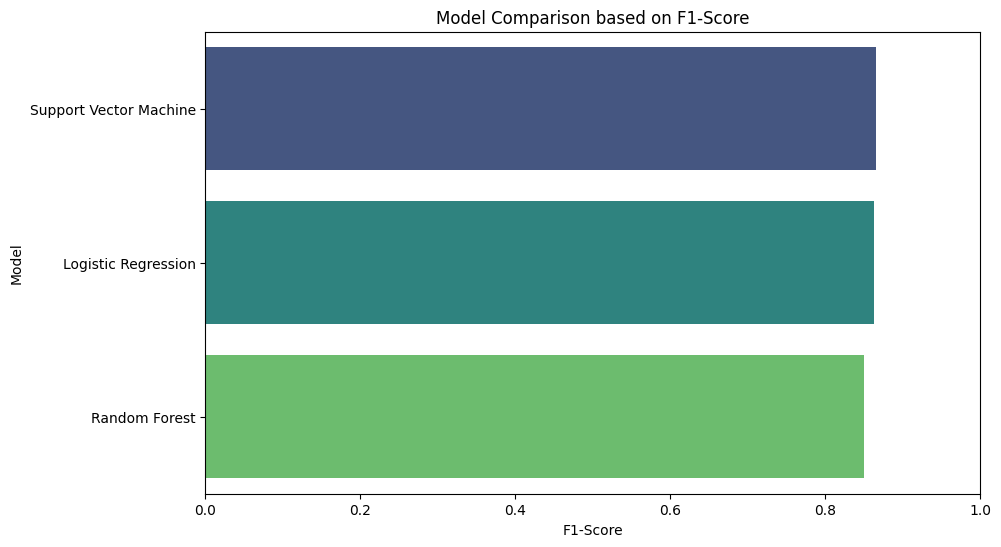

In [38]:
# --- 5.1 Display Results Table ---
# Sort the DataFrame by the F1-Score for a clear comparison
results_df_sorted = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\n--- Model Performance Comparison ---")
print(results_df_sorted)

# --- 5.2 Visualize Model Comparison ---
plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score', y='Model', data=results_df_sorted, hue='Model', palette='viridis', legend=False)
plt.title('Model Comparison based on F1-Score')
plt.xlabel('F1-Score')
plt.ylabel('Model')
plt.xlim(0, 1.0) # Standardize x-axis for better comparison
plt.show()